**Mental Health Text Classification Project**
*Classifying text as Anxiety, Depression, or Suicide Risk using NLP & Logistic Regression* 

In [3]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib


**1. Data Loading**

In [6]:
df1 = pd.read_csv("mental_health.csv") # depression & suicide watch dataset
df2 = pd.read_csv("mental-health (1).csv") # 0 and 1 dataset

df1.head(), df2.head()

(                                                text  label
 0  dear american teens question dutch person hear...      0
 1  nothing look forward lifei dont many reasons k...      1
 2  music recommendations im looking expand playli...      0
 3  im done trying feel betterthe reason im still ...      1
 4  worried  year old girl subject domestic physic...      1,
                                                 text         label
 0  I recently went through a breakup and she said...    depression
 1  I do not know how to navigate these feelings, ...    depression
 2  So I have been with my bf for 5 months , and h...    depression
 3  I am so exhausted of this. Just when I think I...  SuicideWatch
 4  I have been severly bullied since i was 5 till...    depression)

In [8]:
df1.columns = ["text", "label"]
df2.columns = ["text", "label"]

In [10]:
df = pd.concat([df1, df2], ignore_index=True)
df.shape

(48341, 2)

In [12]:
df.dropna(subset=["text", "label"], inplace=True)
df.shape

(48341, 2)

In [14]:
df1['label'].unique(),
df2['label'].unique()


array(['depression', 'SuicideWatch'], dtype=object)

In [16]:
def map_labels(x):
    x = str(x).lower().strip()

    # anxiety class
    if x in ["0", "anxiety"]:
        return "anxiety"

    # depression class
    if x in ["1", "depression"]:
        return "depression"

    # suicide class
    if "suicide" in x or "watch" in x:
        return "suicide"

    # fallback
    return "anxiety"


In [18]:
df["label"] = df["label"].apply(map_labels)
df["label"].value_counts()


label
depression    24209
anxiety       14139
suicide        9993
Name: count, dtype: int64


**2. Data Cleaning and Preprocessing**


In [21]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [23]:
df["clean_text"] = df["text"].apply(clean_text)
df.head()


,text,label,clean_text
0,dear american teens question dutch person hear...,anxiety,dear american teens question dutch person hear...
1,nothing look forward lifei dont many reasons k...,depression,nothing look forward lifei dont many reasons k...
2,music recommendations im looking expand playli...,anxiety,music recommendations im looking expand playli...
3,im done trying feel betterthe reason im still ...,depression,im done trying feel betterthe reason im still ...
4,worried year old girl subject domestic physic...,depression,worried year old girl subject domestic physica...


In [24]:
df.to_csv("cleaned_mental_health.csv", index = False)
print("csv saved successfully")

csv saved successfully


**3. Train & Test**

In [28]:
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**4. TF-IDF**

In [31]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


**5.Logistic Regression**

In [33]:
model = LogisticRegression(max_iter=300)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=300)

In [34]:
preds = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n")
print(classification_report(y_test, preds))


Accuracy: 0.7822939290516082

Classification Report:

              precision    recall  f1-score   support

     anxiety       0.88      0.90      0.89      2828
  depression       0.77      0.82      0.80      4842
     suicide       0.64      0.52      0.57      1999

    accuracy                           0.78      9669
   macro avg       0.76      0.75      0.75      9669
weighted avg       0.78      0.78      0.78      9669



**6. Visualization**

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

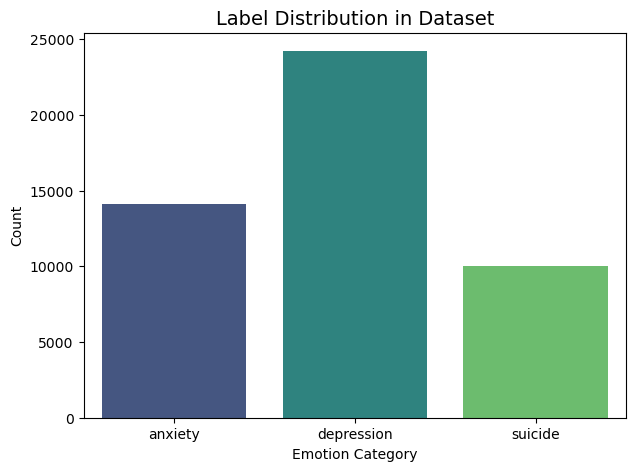

In [37]:
colors = sns.color_palette("viridis", df["label"].nunique())

plt.figure(figsize=(7,5))
sns.countplot(data=df, x="label", hue="label", palette=colors, dodge=False, legend=False)
plt.title("Label Distribution in Dataset", fontsize=14)
plt.xlabel("Emotion Category")
plt.ylabel("Count")
plt.show()

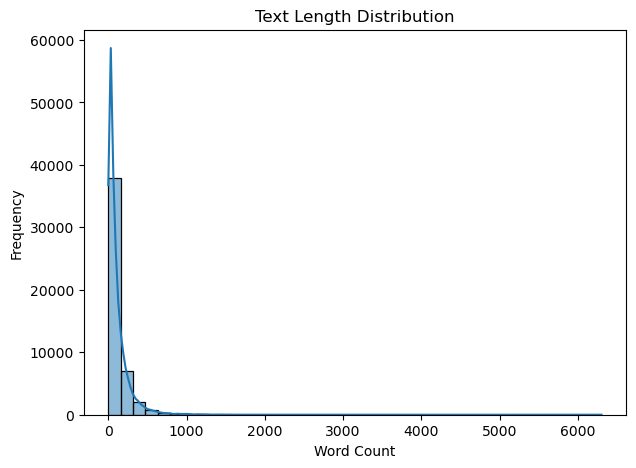

In [38]:
df["text_len"] = df["clean_text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(7,5))
sns.histplot(df["text_len"], bins=40, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

plt.show()

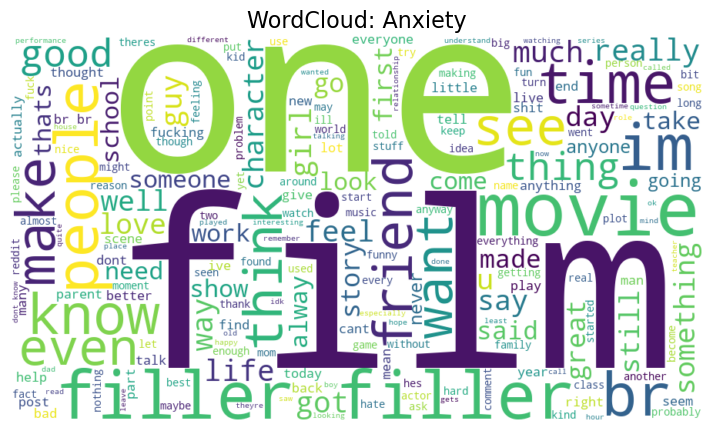

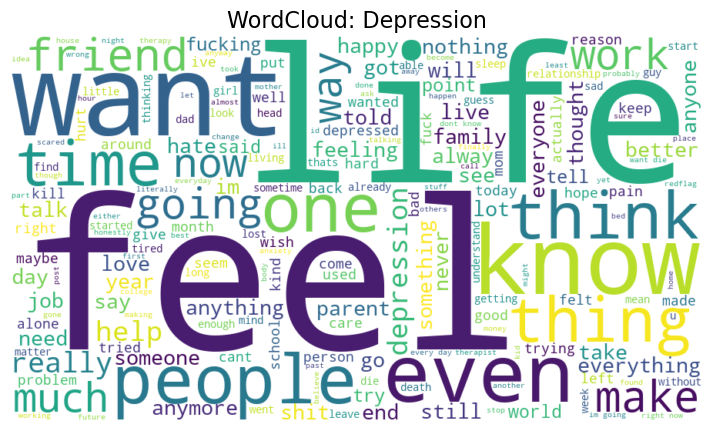

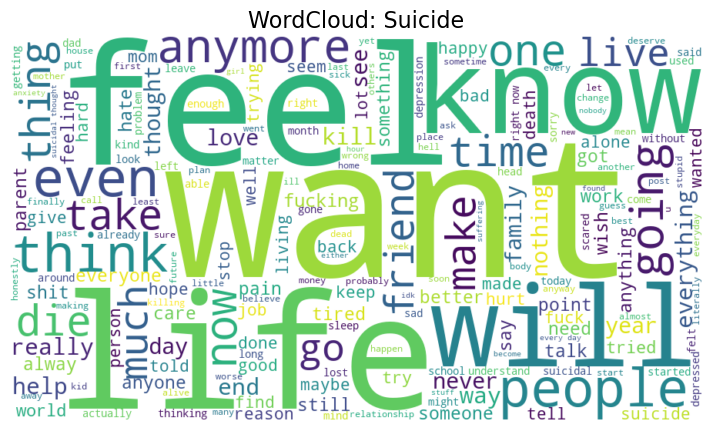

In [39]:
for label in ["anxiety", "depression", "suicide"]:
    text = " ".join(df[df["label"] == label]["clean_text"])
    wc = WordCloud(width=900, height=500, background_color="white").generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(f"WordCloud: {label.capitalize()}", fontsize=16)
    plt.axis("off")

    plt.show()


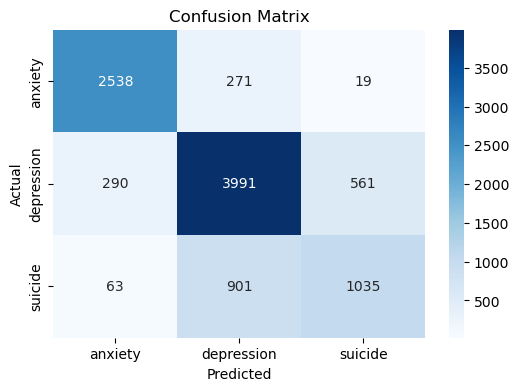

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds, labels=model.classes_)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()


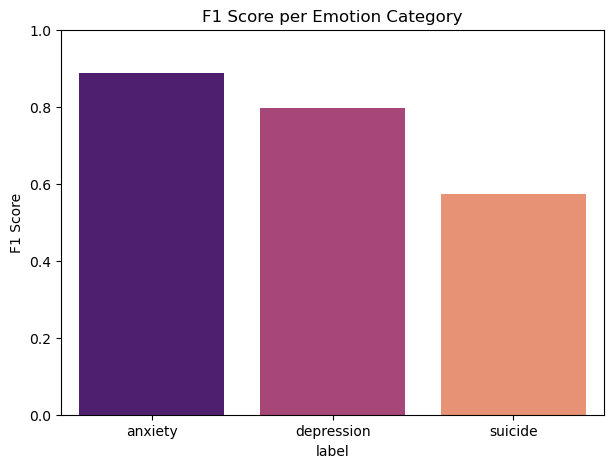

In [49]:
report = classification_report(y_test, preds, output_dict=True)

labels = ["anxiety", "depression", "suicide"]
f1_scores = [report[l]["f1-score"] for l in labels]

# create small df for seaborn
df_plot = pd.DataFrame({
    "label": labels,
    "f1": f1_scores
})

colors = sns.color_palette("magma", len(labels))

plt.figure(figsize=(7,5))
sns.barplot(data=df_plot, x="label", y="f1", hue="label", palette=colors, dodge=False, legend=False)
plt.title("F1 Score per Emotion Category")
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.show()



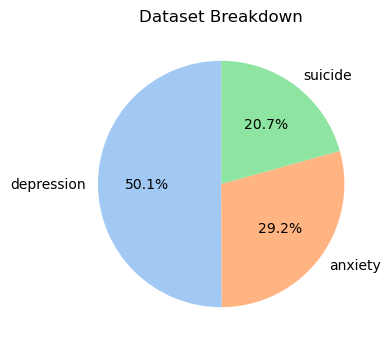

In [51]:
df_counts = df["label"].value_counts()

plt.figure(figsize=(6,4))
df_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90, colors=sns.color_palette("pastel"))
plt.title("Dataset Breakdown")
plt.ylabel("")

plt.show()

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [55]:
df = df
df.head()

,text,label,clean_text,text_len
0,dear american teens question dutch person hear...,anxiety,dear american teens question dutch person hear...,23
1,nothing look forward lifei dont many reasons k...,depression,nothing look forward lifei dont many reasons k...,20
2,music recommendations im looking expand playli...,anxiety,music recommendations im looking expand playli...,64
3,im done trying feel betterthe reason im still ...,depression,im done trying feel betterthe reason im still ...,100
4,worried year old girl subject domestic physic...,depression,worried year old girl subject domestic physica...,311


In [57]:
import nltk
from textblob import TextBlob

df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

df['polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

emotion_strength = df.groupby('label').agg({
    'word_count': 'mean',
    'polarity': 'mean'
}).reset_index()

emotion_strength

,label,word_count,polarity
0,anxiety,47.347054,0.061703
1,depression,131.538271,-0.015945
2,suicide,153.192935,-0.024169


In [58]:
labels = emotion_strength['label'].tolist()
stats = emotion_strength[['word_count', 'polarity']]

# normalize values
stats_norm = (stats - stats.min()) / (stats.max() - stats.min())

# convert to list + close polygon
values = stats_norm.values.tolist()
for v in values:
    v.append(v[0]) # close polygon

# categories (2 features + closure)
categories = ['Word Count Intensity', 'Sentiment Polarity']
categories.append(categories[0])

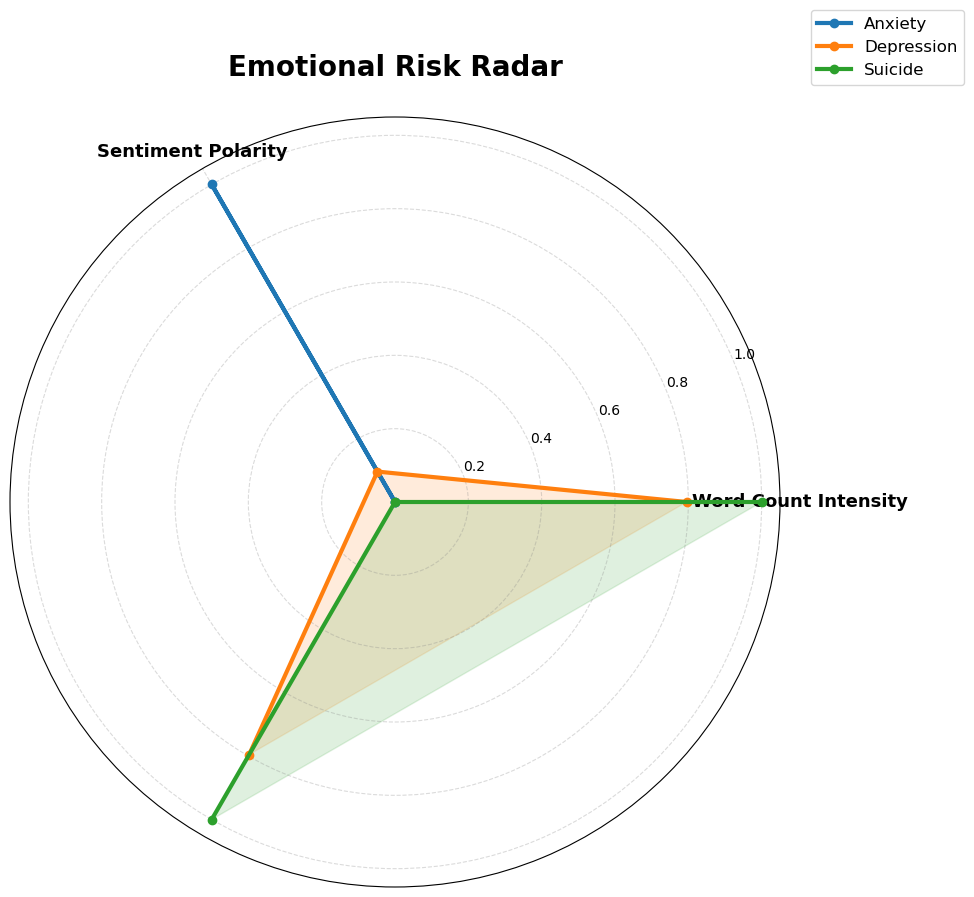

In [59]:
plt.figure(figsize=(10,10))

num_vars = len(categories)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]

# grid styling
plt.rcParams['grid.color'] = "#888"
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# flexible color map — works for lowercase or uppercase
color_map = {
    'anxiety': '#1f77b4',
    'depression': '#ff7f0e',
    'suicide': '#2ca02c'
}

# normalize label text
clean_labels = [lbl.lower() for lbl in labels]

for i, label in enumerate(clean_labels):
    plt.polar(
        angles,
        values[i],
        linewidth=3,
        marker='o',
        markersize=6,
        color=color_map[label],
        label=label.capitalize()
    )
    
    plt.fill(
        angles,
        values[i],
        color=color_map[label],
        alpha=0.15
    )

plt.title("Emotional Risk Radar", fontsize=20, fontweight='bold', pad=30)

plt.xticks(angles[:-1], categories[:-1], fontsize=13, fontweight='bold')

plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15), fontsize=12)


plt.show()


In [60]:
import joblib

joblib.dump(model, "mental_health_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [ ]:
import os
os.listdir()

In [ ]:
import os
os.getcwd()

In [ ]:
pip install --upgrade pip

In [ ]:
pip install streamlit pandas numpy joblib

In [ ]:
import sys
print(sys.executable)

In [ ]:
!D:/anaconda/python.exe -m pip install streamlit pandas numpy joblib

In [ ]:
import os
print(os.path.abspath("app.py"))